<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/MINE_0219.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MINE

In [60]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [52]:
data_size = 20000
cor = [0.5, 1, 1.5, 2, 2.5]

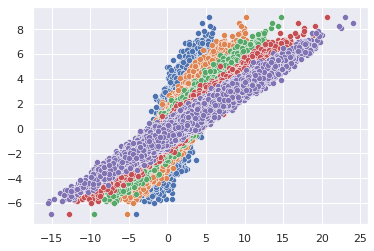

In [149]:
y= np.random.normal(1,2,data_size)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y*cor_ + np.random.normal(1,1,data_size)
    sns.scatterplot(x=x[:,ix],y=y)

In [70]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [150]:
mi_scores = make_mi_scores(pd.DataFrame(x,columns=['x0','x1','x2','x3','x4']), y, discrete_features="auto")
print(mi_scores)

x4    1.629377
x3    1.410347
x2    1.145174
x1    0.813112
x0    0.336452
Name: MI Scores, dtype: float64


(20000, 5)
(20000, 1)


100%|██████████| 300/300 [00:08<00:00, 34.09it/s]


tensor([0.3199, 0.8062, 1.1247, 1.3796, 1.5932], grad_fn=<CopySlices>)


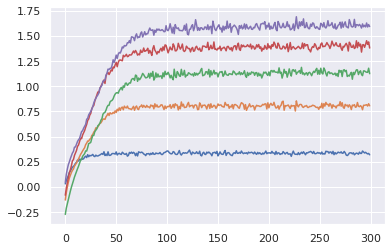

In [162]:
from tqdm import tqdm

H=20
n_epoch = 300
minibatch = 10000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2  

model = [Net() for i in range(x.shape[1])]
optimizer = [torch.optim.Adam(model[i].parameters(), lr=0.01) for i in range(x.shape[1])]

plot_loss = []

y=y.reshape(-1,1)
print(x.shape)
print(y.shape)

for epoch in tqdm(range(n_epoch)):
    back_loss = torch.zeros(5)
    s = np.random.choice(x.shape[0],minibatch)
    for i in range(x.shape[1]):
        x_sample = Variable(torch.from_numpy(x[s,i].reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
        y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
        y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)    
        ret = torch.mean(model[i](x_sample, y_sample)) - torch.log(torch.mean(torch.exp(model[i](x_sample, y_shuffle))))
        loss = - ret  # maximize
        model[i].zero_grad()
        loss.backward()
        optimizer[i].step()
        back_loss[i] = ret

    plot_loss.append(back_loss.data.numpy())


    #back_loss = loss

print('')
print(back_loss)

plot_loss = np.asarray(plot_loss)

plt.plot(plot_loss[:,0])
plt.plot(plot_loss[:,1])
plt.plot(plot_loss[:,2])
plt.plot(plot_loss[:,3])
plt.plot(plot_loss[:,4])

(20000, 5)
(20000, 1)


100%|██████████| 300/300 [00:05<00:00, 53.21it/s]


[0.33105287 0.7961229  1.1299789  1.3878322  1.5870979 ]


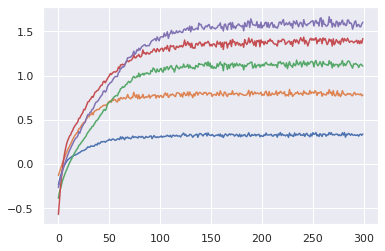

In [195]:
from tqdm import tqdm

H=10
n_epoch = 300
minibatch = 10000

class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()
        
        for i in range(self.input_dim): 
            self.fc1.append(nn.Linear(1, H))
            self.fc2.append(nn.Linear(1, H))
            self.fc3.append(nn.Linear(H, 1))

    def forward(self, x, y):
        h = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](x[:,i].reshape(-1,1))+self.fc2[i](y))
            h.append(self.fc3[i](h0))
        return torch.cat(h, dim=1)  

model = Net(x.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

plot_loss = []

y=y.reshape(-1,1)
print(x.shape)
print(y.shape)

for epoch in tqdm(range(n_epoch)):
    s = np.random.choice(x.shape[0],minibatch)
    x_sample = Variable(torch.from_numpy(x[s,:]).type(torch.FloatTensor), requires_grad = True)
    y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
    y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)    
    p_xy = model(x_sample, y_sample)
    p_x_y = model(x_sample, y_shuffle)
    ret = torch.mean(p_xy,0) - torch.log(torch.mean(torch.exp(p_x_y),0))
    loss = - ret  # maximize
    model.zero_grad()
    loss.mean().backward()
    optimizer.step()

    plot_loss.append(-loss.data.numpy())


    #back_loss = loss

print('')

plot_loss = np.asarray(plot_loss)

print(np.mean(plot_loss[200:,:],0))

plt.plot(plot_loss[:])
